In [13]:
import cv2
import subprocess
import matplotlib.pyplot as plt
import tempfile
import imageio.v3 as iio
import numpy as np
import os

from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from scipy.signal import savgol_filter

In [5]:
ROOT = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input/GX010006_cely-zavit_std-nastaveni.MP4"
# Find out the proper crop
y1 = 550
y2 = 1900
x1 = 1350
x2 = 2650
samples = 1000


In [6]:
vidcap = cv2.VideoCapture(ROOT)
vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

17807.0

In [7]:
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 1679)
success, frame = vidcap.read()

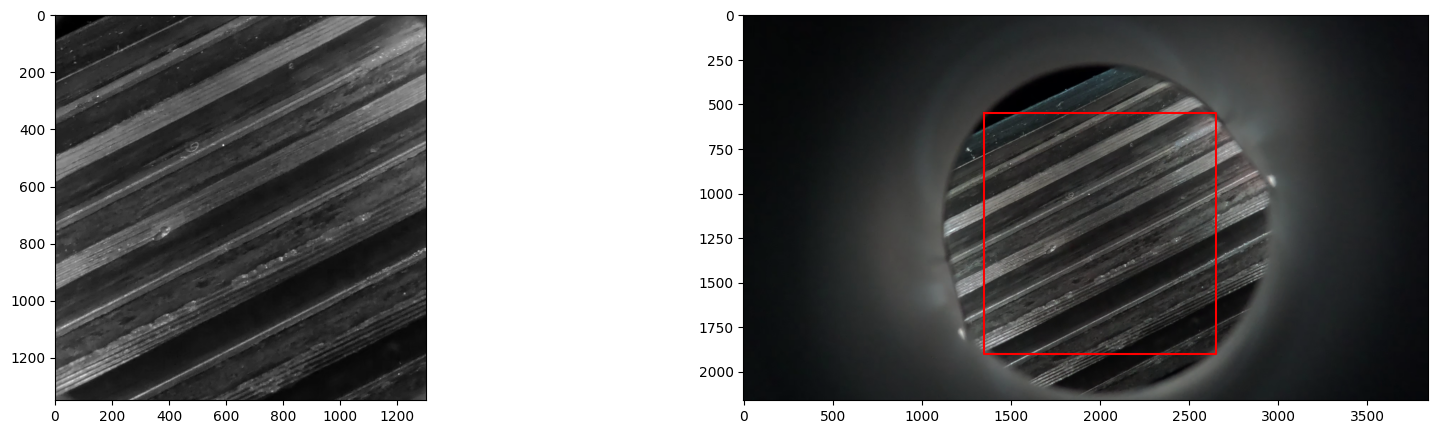

In [8]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(121)
ax.imshow(frame[y1:y2, x1:x2,0], cmap="gray")
ax = plt.subplot(122)
ax.imshow(frame)
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="red")
plt.show()

In [ ]:
def unixPathToWinPath(path):
    return path.replace("/mnt/c/", "C:/").replace("/", "\\\\")

def winPathToUnixPath(path):
    return path.replace("\\", "/").replace("C:/", "/mnt/c/")

In [ ]:
frame_angles = []
hists = []

vidcap = cv2.VideoCapture(ROOT)

frame_rate = 1

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(21220, 21300, frame_rate),  desc="Processing frames"):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    undistorted =  frame[y1:y2, x1:x2, 0]
    undistorted = cv2.resize(undistorted, (undistorted.shape[0]//4, undistorted.shape[1]//4))
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        
        output_path = tmpfile.name.replace(".pgm", ".txt")
        
        process = subprocess.Popen(
            ["wsl", "devernay", winPathToUnixPath(tmpfile.name),
             "-t", winPathToUnixPath(output_path),
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             # "-p", f"/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/sample{i}.pdf",
             "-s", f"1"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        tmpfile.close()
        
    # Wait for the process to complete and get stdout and stderr
    stdout, stderr = process.communicate()
    
    # Check for errors in stderr
    if stderr:
        print("Error running devernay:", stderr.decode("utf-8"))
    if os.path.exists(output_path):
        with open(output_path, 'r') as output_file:
            result = output_file.read()
    else:
        print(f"Output file {output_path} does not exist.")

    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yy1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yy1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan

    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))

    if filename is not None and os.path.exists(filename):
        os.remove(filename)

    # counts, values = np.histogram(filtered, bins=samples)
    hists.append(filtered)
    # frame_angles.append(values[np.argmax(counts)])

In [ ]:
fid = 14
counts, values = np.histogram(hists[fid], bins=samples)
sigma = 1 # Adjust sigma to control the level of smoothing
smoothed_counts = gaussian_filter1d(counts, sigma=sigma)

# Plot the original and smoothed histograms
plt.figure(figsize=(10, 6))
plt.plot(values[:-1], counts, label="Original Histogram", color="blue", alpha=0.7)
plt.plot(values[:-1], smoothed_counts, label="Smoothed Histogram", color="red", linestyle="--", alpha=0.7)

In [ ]:
fid = 14
counts, values = np.histogram(hists[fid], bins=samples)
best = values[np.argmax(counts)]
plt.hist(hists[fid], bins=samples)
plt.axvline(best, color="red")
plt.title(best)
plt.show()

In [ ]:
frame_angles_smoothed = []
for hist in hists:
    counts, values = np.histogram(hist, bins=samples)
    counts = gaussian_filter1d(counts, sigma=2)
    max_index = np.argmax(counts)
    frame_angles_smoothed.append(values[max_index])

In [4]:
frame_angles_smoothed = np.load("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/GX010009_cely zavit clona nahoru-full_angles.npy")

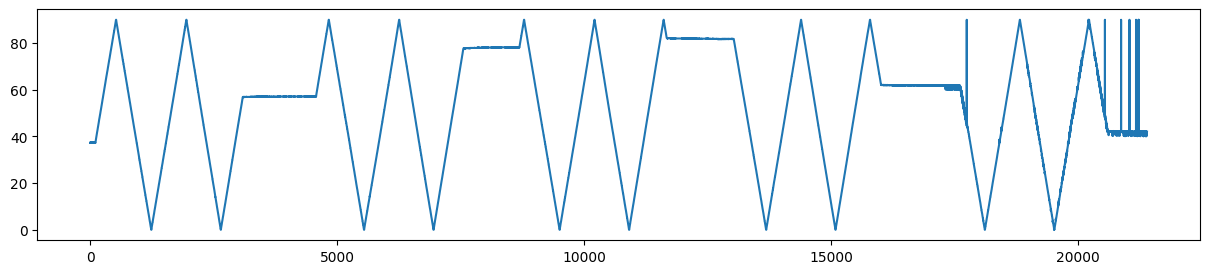

In [5]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [6]:
frame_angles_smoothed_smoothed = savgol_filter(frame_angles_smoothed, window_length=8, polyorder=1)  # Adjust window_length and polyorder based on your data

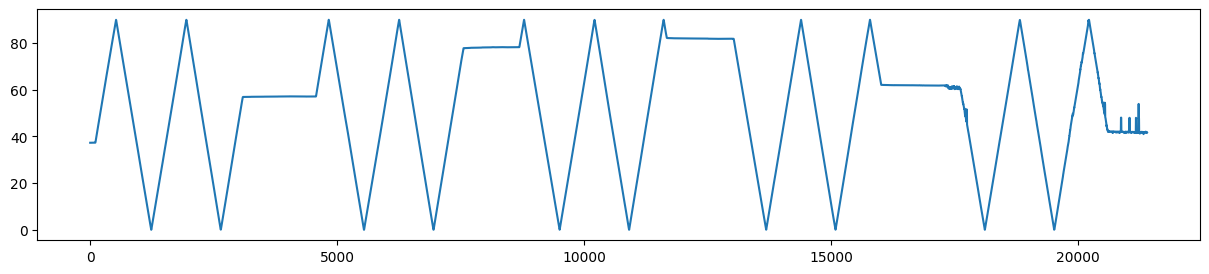

In [7]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed_smoothed)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [8]:
derivative = np.diff(frame_angles_smoothed_smoothed)
threshold = 0.04 # Adjust this threshold based on your data

segment_type = np.zeros_like(derivative)  # Array to store classification: -1 for decreasing, 0 for constant, 1 for increasing

segment_type[derivative > threshold] = 1  # Increasing
segment_type[derivative < -threshold] = -1  # Decreasing
# Constant parts are already set to 0


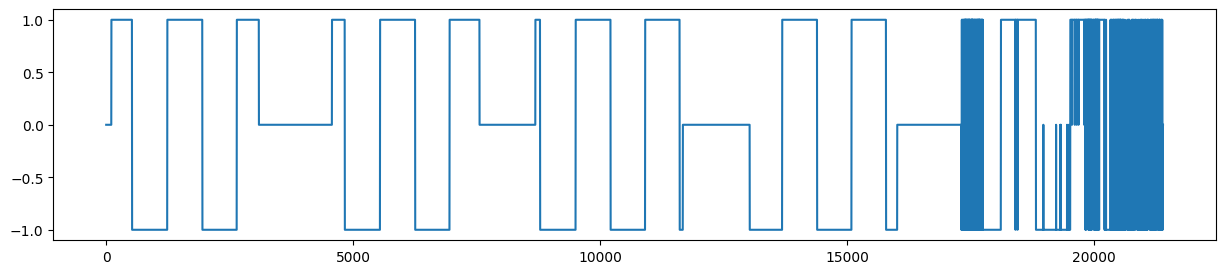

In [9]:
plt.figure(figsize=(15,3))
plt.plot(segment_type)
# plt.axvline(98, color="red")
# plt.axvline(487, color="red")
# plt.axvline(1198, color="red")
# plt.axvline(1895, color="red")
# plt.axvline(2603, color="red")
# plt.axvline(3095, color="red")
plt.show()

In [10]:
breakpoints = np.where(np.diff(segment_type) != 0)[0] + 1  # +1 because np.diff shifts indices by 1

In [11]:
breakpoints

array([  104,   522,   524,  1236,  1238,  1946,  1948,  2643,  2645,
        3091,  4571,  4830,  4832,  5544,  5546,  6255,  6257,  6952,
        6953,  7559,  8690,  8785,  8787,  9505,  9507, 10212, 10214,
       10912, 10914, 11611, 11613, 11676, 13030, 13687, 13689, 14394,
       14396, 15091, 15093, 15790, 15792, 16017, 17319, 17320, 17324,
       17325, 17327, 17328, 17332, 17333, 17340, 17341, 17348, 17349,
       17351, 17352, 17355, 17356, 17358, 17359, 17363, 17364, 17366,
       17368, 17372, 17375, 17377, 17380, 17381, 17382, 17383, 17384,
       17385, 17386, 17388, 17389, 17390, 17392, 17394, 17395, 17396,
       17397, 17399, 17400, 17401, 17405, 17406, 17407, 17408, 17409,
       17411, 17412, 17413, 17414, 17415, 17416, 17417, 17418, 17419,
       17423, 17424, 17426, 17427, 17429, 17431, 17432, 17435, 17436,
       17439, 17442, 17443, 17444, 17445, 17446, 17447, 17448, 17450,
       17451, 17454, 17455, 17456, 17458, 17460, 17462, 17463, 17464,
       17466, 17467,

In [12]:
threshold = 5
step = 1
# Define the distance threshold to group close breakpoints

merged_breakpoints = []

# Temporary group for close breakpoints
current_group = [breakpoints[0]]

# Iterate over the breakpoints
for i in range(1, len(breakpoints)):
    # print(breakpoints[i], breakpoints[i - 1], breakpoints[i] - breakpoints[i - 1] <= threshold)
    # If the difference between consecutive breakpoints is below the threshold, group them
    if breakpoints[i] - breakpoints[i - 1] <= threshold:
        current_group.append(breakpoints[i])
    else:
        # If a current group is finished, calculate the rounded average and store it
        avg_breakpoint = int(round(np.mean(current_group)))
        merged_breakpoints.append(avg_breakpoint)
        # Start a new group
        current_group = [breakpoints[i]]

# Handle the last group
if current_group:
    avg_breakpoint = int(round(np.mean(current_group)))
    merged_breakpoints.append(avg_breakpoint)

# print(np.asarray(merged_breakpoints))

if len(merged_breakpoints) > 1:
    if stats.mode(segment_type[:merged_breakpoints[0]//step])[0] == stats.mode(segment_type[merged_breakpoints[0]//step:merged_breakpoints[1]//step])[0]:
        new_merged_breakpoints = []
    else:
        new_merged_breakpoints = [merged_breakpoints[0]]

    for i in range(1, len(merged_breakpoints) - 1):
        # print(i, stats.mode(self.segment_type[merged_breakpoints[i - 1]:merged_breakpoints[i]])[0], stats.mode(self.segment_type[merged_breakpoints[i]:merged_breakpoints[i + 1]])[0])
        if not stats.mode(segment_type[merged_breakpoints[i - 1]//step:merged_breakpoints[i]//step])[0] == stats.mode(segment_type[merged_breakpoints[i]//step:merged_breakpoints[i + 1]//step])[0]:
            new_merged_breakpoints.append(merged_breakpoints[i])

    if not stats.mode(segment_type[merged_breakpoints[-1]//step:])[0] == stats.mode(segment_type[merged_breakpoints[-2]//step:merged_breakpoints[-1]//step])[0]:
        new_merged_breakpoints.append(merged_breakpoints[-1])

new_merged_breakpoints = np.concatenate([[0], new_merged_breakpoints, [(len(frame_angles_smoothed) - 1) * step]])
# Now merged_breakpoints contains the final list of unique breakpoints
print("Merged Breakpoints:", new_merged_breakpoints)


Merged Breakpoints: [    0   104   523  1237  1947  2644  3091  4571  4831  5545  6256  6952
  7559  8690  8786  9506 10213 10913 11612 11676 13030 13688 14395 15092
 15791 16017 17635 18116 18826 19522 20226 20606 21401]


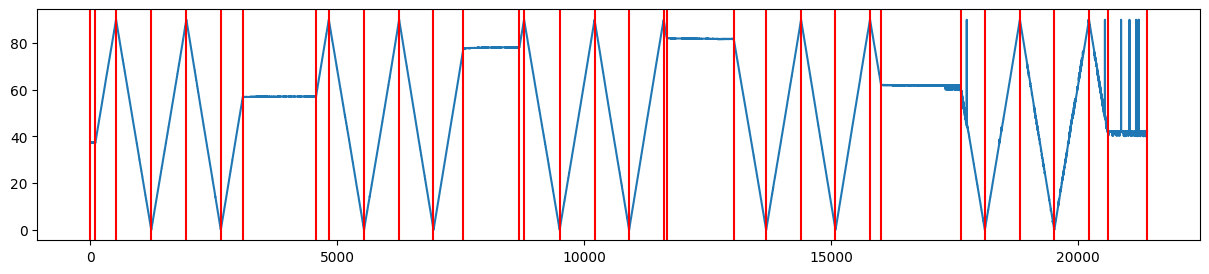

In [13]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles_smoothed)
# plt.plot(segment_type)
for bp in new_merged_breakpoints:
    plt.axvline(bp, color="red")
plt.show()

In [14]:
borderBreakpoints = []
for i in range(0, len(new_merged_breakpoints) - 1):
    if stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0] == 0:
        borderBreakpoints.append([new_merged_breakpoints[i], new_merged_breakpoints[i + 1]])

print(f"Calculated: Border Breakpoints\n"
      f"{np.asarray(borderBreakpoints)}\n")

Calculated: Border Breakpoints
[[    0   104]
 [ 3091  4571]
 [ 7559  8690]
 [11676 13030]
 [16017 17635]
 [20606 21401]]



In [15]:
np.max(frame_angles_smoothed)

np.float32(89.91)

In [16]:
frame_angles_smoothed[3090:3100]

array([56.79, 56.88, 56.79, 56.79, 56.88, 56.79, 56.88, 56.88, 56.88,
       56.88], dtype=float32)

In [17]:
np.where(np.array(frame_angles_smoothed)==np.min(frame_angles_smoothed))

(array([ 1235,  1236,  1237,  1238,  1239,  2643,  2644,  2645,  2646,
         5543,  5544,  5545,  5546,  5547,  5548,  6951,  6952,  6953,
         6954,  6955,  9504,  9505,  9506,  9507,  9508, 10911, 10912,
        10913, 10914, 10915, 10916, 13687, 13688, 13689, 13690, 13691,
        15091, 15092, 15093, 15094, 18114, 18115, 18116, 18117, 18118,
        18119, 19518, 19522, 19523, 19524, 19525]),)

In [18]:
np.where(np.array(frame_angles_smoothed)==np.max(frame_angles_smoothed))

(array([  522,   523,   524,   525,   526,  1946,  1947,  1948,  1949,
         1950,  4830,  4831,  4832,  4833,  4834,  6254,  6255,  6256,
         6257,  6258,  6259,  8784,  8785,  8786,  8787,  8788, 10212,
        10213, 10214, 10215, 11611, 11612, 11613, 11614, 11615, 14394,
        14395, 14396, 14397, 15789, 15790, 15791, 15792, 15793, 15794,
        17751, 18825, 18826, 18827, 18828, 20211, 20212, 20213, 20214,
        20224, 20225, 20226, 20227, 20228, 20549, 20876, 21046, 21179,
        21229, 21236]),)

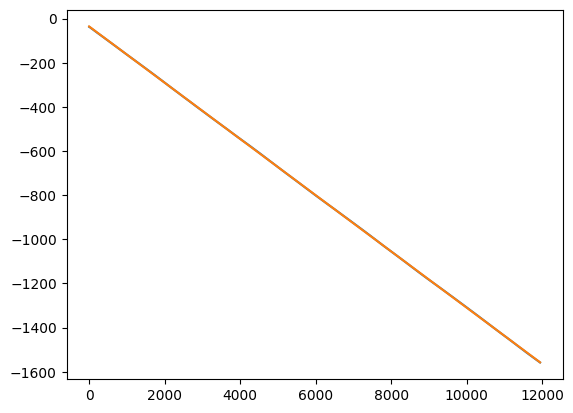

Calculated : RotationPerFrame
0.12734514911853811


In [19]:
fa = []
j = 0
if frame_angles_smoothed[breakpoints[2]] < frame_angles_smoothed[breakpoints[3]]:
    k=0
else:
    k=1
start, end = borderBreakpoints[j]
for i in range(0, 27 - 1):
    if not start == new_merged_breakpoints[i]:
        segment = -stats.mode(segment_type[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]])[0]
        offset = -(k // 2 * 180)
        if not start == new_merged_breakpoints[i + 1]:
            k += 1
        f = frame_angles_smoothed[new_merged_breakpoints[i]:new_merged_breakpoints[i + 1]] * segment + offset
        fa = np.concatenate([fa, f])
    else:
        j += 1
        if j < len(borderBreakpoints):
            start, end = borderBreakpoints[j]

a, b = np.polyfit(np.arange(len(fa)), fa, 1)

plt.plot(fa)
plt.plot([(a * x + b) for x in np.arange(len(fa))])
plt.show()

print(f"Calculated : RotationPerFrame\n"
      f"{-a}")

In [ ]:
# fa = np.concatenate([frame_angles_smoothed[96:488], -frame_angles_smoothed[488:1198], -180 + frame_angles_smoothed[1198: 1895], -180 - frame_angles_smoothed[1895: 2603], -360 + frame_angles_smoothed[2603: 3095]])
a, b = np.polyfit(np.arange(len(fa)), fa, 1)

In [ ]:
plt.plot(fa)
plt.plot([(a*x + b) for x in np.arange(len(fa))])
plt.show()

In [ ]:
rot = -a
angle = -rot*(487-98)
rotated = []

vidcap = cv2.VideoCapture(ROOT)

# total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames = 3095-98

success, frame = vidcap.read()

vidcap.set(cv2.CAP_PROP_POS_FRAMES, 98)

out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*'h264'),
                      fps=20.0,
                      frameSize=(y2-y1, x2-x1),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ]
                      )

for i in tqdm(range(total_frames), desc="Processing frames"):
    success, frame = vidcap.read()
    rotate_matrix = cv2.getRotationMatrix2D((frame.shape[1]/2, frame.shape[0]/2), angle, 1)    
    rotated_image = cv2.warpAffine( 
        src=frame, M=rotate_matrix, dsize=(frame.shape[1], frame.shape[0]))[y1: y2, x1:x2, 0]
    
    out.write(rotated_image.astype(np.uint8))
    
    angle += rot
    
out.release()

In [ ]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
out = cv2.VideoWriter('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=10.0,
                      frameSize=(rotated[0].shape[1], rotated[0].shape[0]),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ])
for frame in tqdm(rotated):
    out.write(frame.astype(np.uint8))
out.release()


In [ ]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(121)
ax.imshow(rotated[10], cmap="gray")
ax = plt.subplot(122)
ax.imshow(rotated[200], cmap="gray")
plt.show()

In [ ]:
np.max(rotated)

In [ ]:
rot